In [34]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tsfel
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

## **QUESTION 1**

### DATA HANDALING

UCI HAR Dataset

In [35]:
basePath = r"UCI HAR Dataset"

features = pd.read_csv(basePath+"/features.txt", sep="\s+", header=None, names=["index", "feature"])
feature_names = features["feature"].values

X_train_UCI = pd.read_csv(basePath+"/train/X_train.txt", sep="\s+", header=None)
y_train_UCI = pd.read_csv(basePath+"/train/y_train.txt", sep="\s+", header=None, names=['Activity'])

X_test_UCI = pd.read_csv(basePath+"/test/X_test.txt", sep="\s+", header=None)
y_test_UCI = pd.read_csv(basePath+"/test/y_test.txt", sep="\s+", header=None, names=['Activity'])

activity_labels = pd.read_csv(basePath+"/activity_labels.txt", sep="\s+", header=None, names=["ActivityID", "ActivityName"])

y_train_UCI = y_train_UCI.merge(activity_labels, left_on="Activity", right_on="ActivityID").drop(["Activity", "ActivityID"], axis=1)
y_test_UCI = y_test_UCI.merge(activity_labels, left_on="Activity", right_on="ActivityID").drop(["Activity", "ActivityID"], axis=1)

trim = 0.025
start = int(len(X_train_UCI) * trim)
end = len(X_train_UCI) - start

X_train_UCI = X_train_UCI.iloc[start:end].reset_index(drop=True)
y_train_UCI = y_train_UCI.iloc[start:end].reset_index(drop=True)

Combine/ Raw data

In [36]:
basePath = r"Combined/Train"

activities = os.listdir(basePath)

data_list = []
for acitivity in activities:
    folder_path = os.path.join(basePath,acitivity)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path,file)
        df = pd.read_csv(file_path)
        df['activity'] = acitivity
        data_list.append(df)

data = pd.concat(data_list,ignore_index=True)
print(data.head())

X_train_combined = data[['accx','accy','accz']]
y_train_combined = data['activity']
y_train_combined = y_train_combined.astype('category')

       accx      accy      accz activity
0  0.181141  0.787813  0.581194   LAYING
1  0.180389  0.788230  0.584017   LAYING
2  0.184572  0.788880  0.580620   LAYING
3  0.187104  0.788494  0.574279   LAYING
4  0.186461  0.786544  0.570184   LAYING


In [37]:
basePath = r"Combined/Test"

activities = os.listdir(basePath)

data_list = []
for acitivity in activities:
    folder_path = os.path.join(basePath,acitivity)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path,file)
        df = pd.read_csv(file_path)
        df['activity'] = acitivity
        data_list.append(df)

data = pd.concat(data_list,ignore_index=True)
print(data.head())

X_test_combined = data[['accx','accy','accz']]
y_test_combined = data['activity']
y_test_combined = y_test_combined.astype('category')

       accx      accy      accz activity
0  0.088848  0.944508  0.306267   LAYING
1  0.089700  0.981510  0.289673   LAYING
2  0.089773  0.983380  0.291745   LAYING
3  0.073487  0.971434  0.287301   LAYING
4  0.049321  0.952625  0.278895   LAYING


TSFEL

In [38]:
basePath = r"Combined/Train"
activities = os.listdir(basePath)

cfg = tsfel.get_features_by_domain()

feature_list = []

for activity in activities:
    folder_path = os.path.join(basePath, activity)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        features_x = tsfel.time_series_features_extractor(cfg, df['accx'],50, verbose=0)
        features_y = tsfel.time_series_features_extractor(cfg, df['accy'],50, verbose=0)
        features_z = tsfel.time_series_features_extractor(cfg, df['accz'],50, verbose=0)

        combined_features = pd.concat([features_x, features_y, features_z], axis=1)
        combined_features['activity'] = activity

        feature_list.append(combined_features)

feature_data = pd.concat(feature_list, ignore_index=True)
X_train_tsfel = feature_data.drop(columns=['activity'])
y_train_tsfel = feature_data['activity'].astype('category')

basePath = r"Combined/Test"
activities = os.listdir(basePath)

cfg = tsfel.get_features_by_domain()

feature_list = []

for activity in activities:
    folder_path = os.path.join(basePath, activity)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        features_x = tsfel.time_series_features_extractor(cfg, df['accx'],50, verbose=0)
        features_y = tsfel.time_series_features_extractor(cfg, df['accy'],50, verbose=0)
        features_z = tsfel.time_series_features_extractor(cfg, df['accz'],50, verbose=0)

        combined_features = pd.concat([features_x, features_y, features_z], axis=1)
        combined_features['activity'] = activity

        feature_list.append(combined_features)

feature_data = pd.concat(feature_list, ignore_index=True)
X_test_tsfel = feature_data.drop(columns=['activity'])
y_test_tsfel = feature_data['activity'].astype('category')

### MODEL UCI FEATURES

Accuracy: 0.8612147947064812
Precision: 0.8624614102808118
Recall: 0.8612147947064812


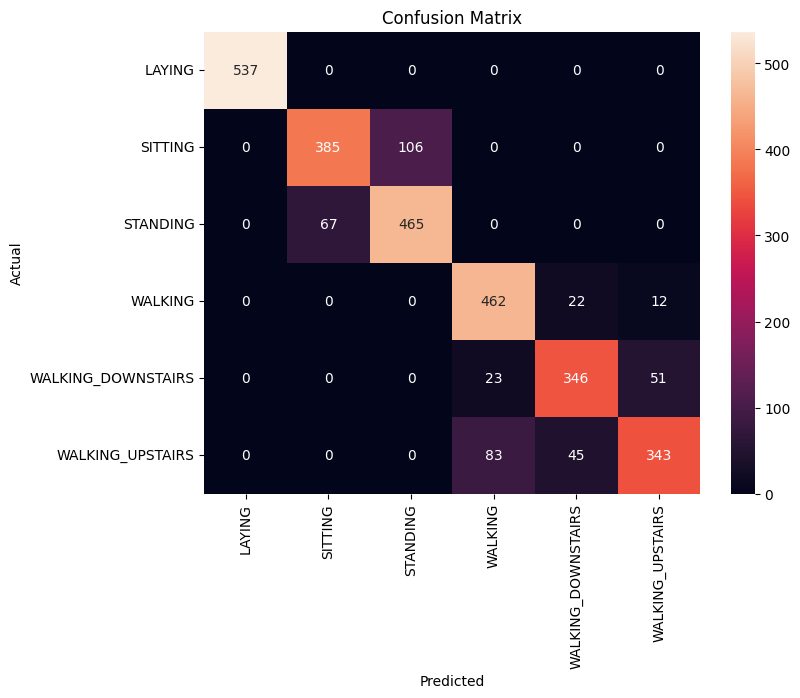

In [39]:
model_UCI = DecisionTreeClassifier(criterion='gini',max_depth=None,random_state=42)
model_UCI.fit(X_train_UCI,y_train_UCI)

y_pred_UCI = model_UCI.predict(X_test_UCI)

accuracy_UCI = accuracy_score(y_test_UCI,y_pred_UCI)
precision_UCI = precision_score(y_test_UCI, y_pred_UCI, average='weighted')
recall_UCI = recall_score(y_test_UCI, y_pred_UCI, average='weighted')
cm_UCI = confusion_matrix(y_test_UCI, y_pred_UCI)

print("Accuracy:", accuracy_UCI)
print("Precision:", precision_UCI)
print("Recall:", recall_UCI)

plt.figure(figsize=(8,6))
sns.heatmap(cm_UCI, annot=True, fmt='d', xticklabels=model_UCI.classes_, yticklabels=model_UCI.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### MODEL TSFEL 

Accuracy: 0.8518518518518519
Precision: 0.8544191919191919
Recall: 0.8518518518518519


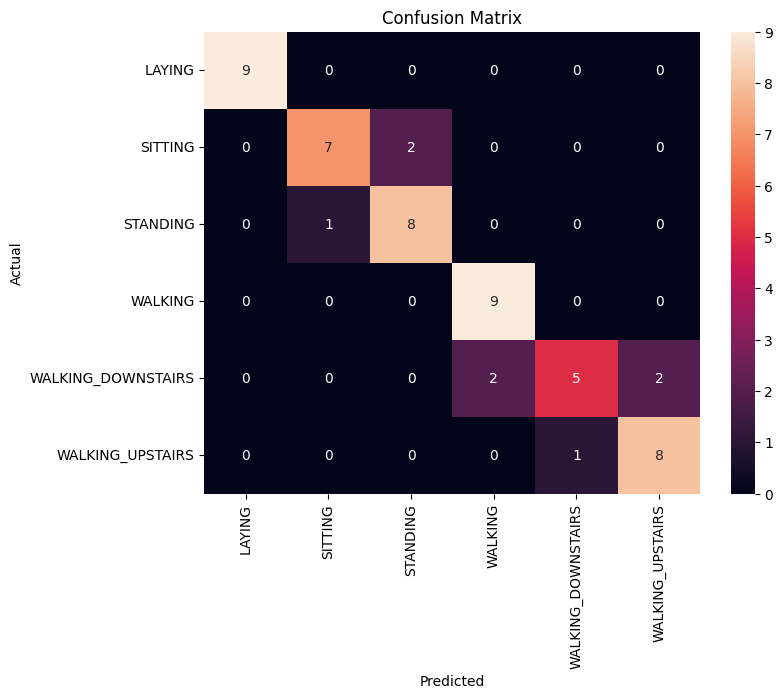

In [40]:
model_tsfel = DecisionTreeClassifier(criterion='gini',max_depth=None,random_state=42)
model_tsfel.fit(X_train_tsfel,y_train_tsfel)

y_pred_tsfel = model_tsfel.predict(X_test_tsfel)

accuracy_tsfel = accuracy_score(y_test_tsfel, y_pred_tsfel)
precision_tsfel = precision_score(y_test_tsfel, y_pred_tsfel, average='weighted')
recall_tsfel = recall_score(y_test_tsfel, y_pred_tsfel, average='weighted')
cm_tsfel = confusion_matrix(y_test_tsfel, y_pred_tsfel)

print("Accuracy:", accuracy_tsfel)
print("Precision:", precision_tsfel)
print("Recall:", recall_tsfel)
plt.figure(figsize=(8,6))
sns.heatmap(cm_tsfel, annot=True, fmt='d', xticklabels=model_tsfel.classes_, yticklabels=model_tsfel.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### MODEL ACCELEROMETER

Accuracy: 0.5602254411265694
Precision: 0.5944154397040211
Recall: 0.5602254411265694


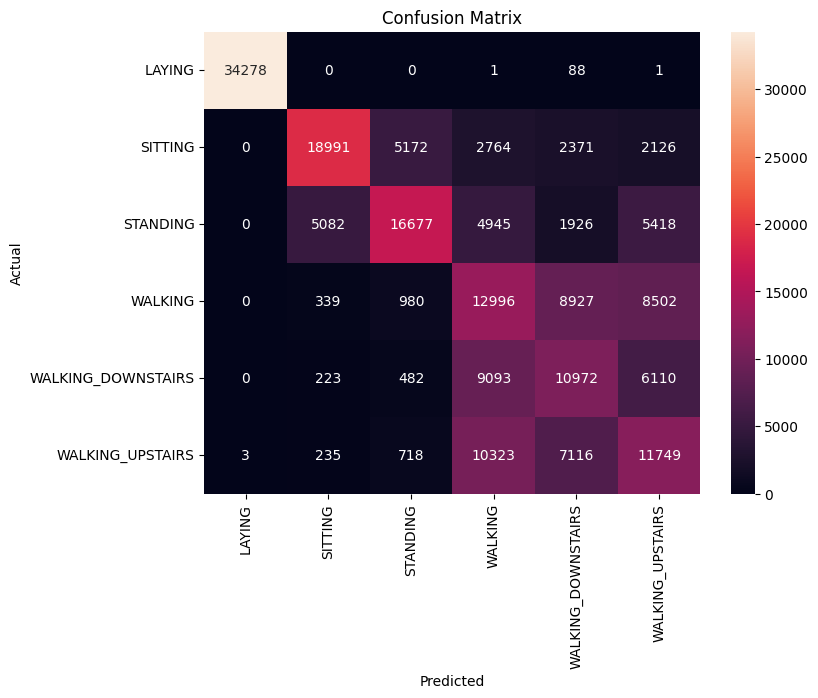

In [41]:
model_combined = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
model_combined.fit(X_train_combined,y_train_combined)

y_pred_combined = model_combined.predict(X_test_combined)

accuracy_combined = accuracy_score(y_test_combined, y_pred_combined)
precision_combined = precision_score(y_test_combined, y_pred_combined, average='weighted')
recall_combined = recall_score(y_test_combined, y_pred_combined, average='weighted')
cm_combined = confusion_matrix(y_test_combined, y_pred_combined)

print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)

plt.figure(figsize=(8,6))
sns.heatmap(cm_combined, annot=True, fmt='d', xticklabels=model_combined.classes_, yticklabels=model_combined.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### VERDICT

The three models have different accuracies

**Model 3 Acceleration:** Accuracy: 0.5602254411265694
Precision: 0.5944154397040211
Recall: 0.5602254411265694

**Model 2 TSFEL:** Accuracy: 0.8518518518518519
Precision: 0.8544191919191919
Recall: 0.8518518518518519

**Model 1 UCI Features:** Accuracy: 0.8622327790973872
Precision: 0.8632726592620287
Recall: 0.8622327790973872

We observe its close between the model 2 and model 1 but they both have clear advantage over model 3.

## **QUESTION 2**

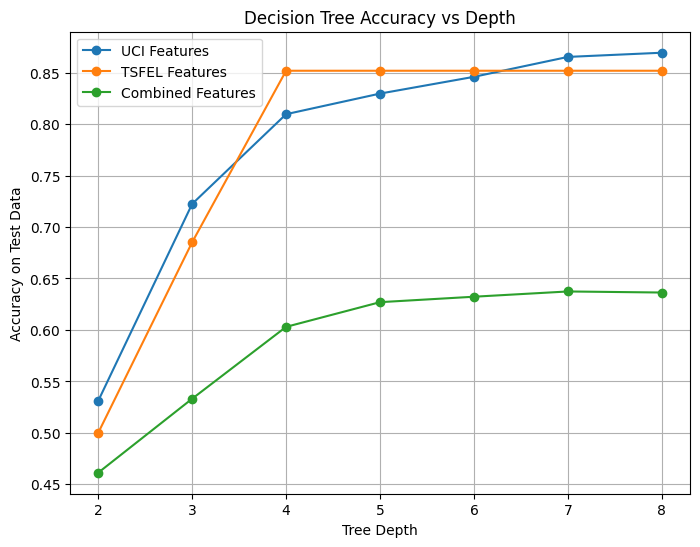

In [42]:
depths = range(2, 9)

accuracy_uci = []
accuracy_tsfel = []
accuracy_combined = []

for depth in depths:
    # UCI model
    model_uci = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_uci.fit(X_train_UCI, y_train_UCI)
    y_pred_uci = model_uci.predict(X_test_UCI)
    accuracy_uci.append(accuracy_score(y_test_UCI, y_pred_uci))

    # TSFEL model
    model_tsfel = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_tsfel.fit(X_train_tsfel, y_train_tsfel)
    y_pred_tsfel = model_tsfel.predict(X_test_tsfel)
    accuracy_tsfel.append(accuracy_score(y_test_tsfel, y_pred_tsfel))

    # Combined model
    model_combined = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_combined.fit(X_train_combined, y_train_combined)
    y_pred_combined = model_combined.predict(X_test_combined)
    accuracy_combined.append(accuracy_score(y_test_combined, y_pred_combined))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(depths, accuracy_uci, marker='o', label='UCI Features')
plt.plot(depths, accuracy_tsfel, marker='o', label='TSFEL Features')
plt.plot(depths, accuracy_combined, marker='o', label='Combined Features')

plt.title('Decision Tree Accuracy vs Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy on Test Data')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

## **QUESTION 3**

We see from the confusion matrix that our models generally get confused between walking, upstairs and downstairs. It is not able to diffrentiate the motion in Y-direction